In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [4]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

In [5]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [6]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,1] * y_pred[:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,1])) + K.sum(K.square(y_pred[:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,2] * y_pred[:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,2])) + K.sum(K.square(y_pred[:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,3] * y_pred[:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,3])) + K.sum(K.square(y_pred[:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [9]:
from keras.layers import Input, Conv2D, Dropout,concatenate, BatchNormalization, UpSampling2D, ReLU, MaxPooling2D, Conv2DTranspose, Cropping2D, Concatenate, Softmax
from keras import Model

def build_unet(inputs, ker_init, dropout):
    #encoder0
    conva = Conv2D(16, (3, 3), padding='same')(inputs) #2
    bna = BatchNormalization()(conva) #3
    ra= ReLU()(bna) #4
    convb = Conv2D(32, (3, 3), padding='same')(ra) #5
    bnb = BatchNormalization()(convb) #6
    rb= ReLU()(bnb) #7
    maxpoola = MaxPooling2D(pool_size=(2, 2))(rb) #8
    
    #encoder1
    conv1 = Conv2D(32, (3, 3), padding='same')(maxpoola) #2
    bn1 = BatchNormalization()(conv1) #3
    r1= ReLU()(bn1) #4
    conv2 = Conv2D(64, (3, 3), padding='same')(r1) #5
    bn2 = BatchNormalization()(conv2) #6
    r2= ReLU()(bn2) #7
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(r2) #8

    #encoder2
    conv3 =  Conv2D(64, (3, 3),  padding='same')(maxpool1) #9
    bn3 =  BatchNormalization()(conv3) #10
    r3= ReLU()(bn3) #11
    conv4 =  Conv2D(128, (3, 3), padding='same')(r3) #12
    bn4 =  BatchNormalization()(conv4) #13
    r4= ReLU()(bn4) #14
    maxpool2 =  MaxPooling2D(pool_size=(2, 2))(r4) #15

    #encoder 3
    conv5 =  Conv2D(128, (3, 3), padding='same')(maxpool2) #16
    bn5 =  BatchNormalization()(conv5) #17
    r5= ReLU()(bn5) #18
    conv6 =  Conv2D(256, (3, 3), padding='same')(r5) #19
    bn6 =  BatchNormalization()(conv6) #20
    r6= ReLU()(bn6) #21
    maxpool3 =  MaxPooling2D(pool_size=(2, 2))(r6) #22

    #encoding ends decoding starts
    conv7 =  Conv2D(256, (3, 3), padding='same')(maxpool3) #23
    bn7 =  BatchNormalization()(conv7) #24
    r7= ReLU()(bn7) #25
    conv8 =  Conv2D(512, (3, 3), padding='same')(r7) #25
    bn8 =  BatchNormalization()(conv8) #27
    r8= ReLU()(bn8) #28
    upsample1 =  Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(r8) #29

    #decoder1
    crop1 =  Cropping2D(cropping=((0, 0), (0, 0)))(r6) #30
    concat1 =  Concatenate(axis=-1)([upsample1, crop1]) #31
    conv9 =  Conv2D(256, (3, 3), padding='same')(concat1) #32
    bn9 =  BatchNormalization()(conv9) #33
    r9= ReLU()(bn9) #34
    conv10 =  Conv2D(256, (3, 3), padding='same')(r9) #35
    bn10 =  BatchNormalization()(conv10) #36
    r10= ReLU()(bn10) #37
    upsample2 =  Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(r10) #38

    #decoder2
    crop2 = Cropping2D(cropping=((0, 0), (0, 0)))(r4) #39
    concat2 =  Concatenate(axis=-1)([upsample2, crop2]) #40
    conv11 =  Conv2D(128, (3, 3), padding='same')(concat2) #41
    bn11 =  BatchNormalization()(conv11) #42
    r11= ReLU()(bn11) #43
    conv12 =  Conv2D(128, (3, 3), padding='same')(r11) #44
    bn12 =  BatchNormalization()(conv12) #45
    r12= ReLU()(bn12) #46
    upsample3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(r12) #47

    #decoder3
    crop3 =  Cropping2D(cropping=((0, 0), (0, 0)))(r2) #48
    concat3 =  Concatenate(axis=-1)([upsample3, crop3])  #49
    conv13 =  Conv2D(64, (3, 3), padding='same')(concat3) #50
    bn13 =  BatchNormalization()(conv13) #51
    r13= ReLU()(bn13) #52
    conv14 =  Conv2D(64, (3, 3), padding='same')(r13) #53
    bn14 =  BatchNormalization()(conv14) #54
    r14= ReLU()(bn14) #55
    upsample4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(r14) #47
    
    #decoder4
    crop4 =  Cropping2D(cropping=((0, 0), (0, 0)))(rb) #48
    concat4 =  Concatenate(axis=-1)([upsample4, crop4])  #49
    conv15 =  Conv2D(32, (3, 3), padding='same')(concat4) #50
    bn15 =  BatchNormalization()(conv15) #51
    r15= ReLU()(bn15) #52
    conv16 =  Conv2D(32, (3, 3), padding='same')(r15) #53
    bn16 =  BatchNormalization()(conv16) #54
    r16= ReLU()(bn16) #55
    conv17 =  Conv2D(3, (3, 3), padding='same')(r16) #56

    output =  Softmax()(conv17) #57

    # 2D Pixel Classification Layer
    num_classes = 4 
    output = Conv2D(num_classes, (1, 1), activation='softmax')(output)
    return Model(inputs=inputs, outputs=output)



input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
model1 = build_unet(input_layer, 'he_normal', 0.2)
model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                         dice_coef, precision, sensitivity, specificity,
                         dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [10]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  304         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

filepath="/kaggle/working/3D-UNet-2021-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('/kaggle/working/training_2021_2D_UNet.log')

history =  model1.fit(training_generator,
                    epochs=45, batch_size=1,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )

Epoch 1/45
850/850 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.9761 - mean_io_u: 0.3755 - dice_coef: 0.6914 - precision: 0.8595 - sensitivity: 0.8481 - specificity: 0.9978 - dice_coef_necrotic: 0.8888 - dice_coef_edema: 0.8886 - dice_coef_enhancing: 0.8887
Epoch 1: val_accuracy improved from -inf to 0.97872, saving model to /kaggle/working/3D-UNet-2021-weights-improvement-01-0.979.hdf5
850/850 [==============================] - 520s 573ms/step - loss: 0.4203 - accuracy: 0.9761 - mean_io_u: 0.3755 - dice_coef: 0.6914 - precision: 0.8595 - sensitivity: 0.8481 - specificity: 0.9978 - dice_coef_necrotic: 0.8888 - dice_coef_edema: 0.8886 - dice_coef_enhancing: 0.8887 - val_loss: 0.1998 - val_accuracy: 0.9787 - val_mean_io_u: 0.3755 - val_dice_coef: 0.8700 - val_precision: 0.9880 - val_sensitivity: 0.9707 - val_specificity: 0.9961 - val_dice_coef_necrotic: 0.9872 - val_dice_coef_edema: 0.9872 - val_dice_coef_enhancing: 0.9872
Epoch 2/45
850/850 [==================

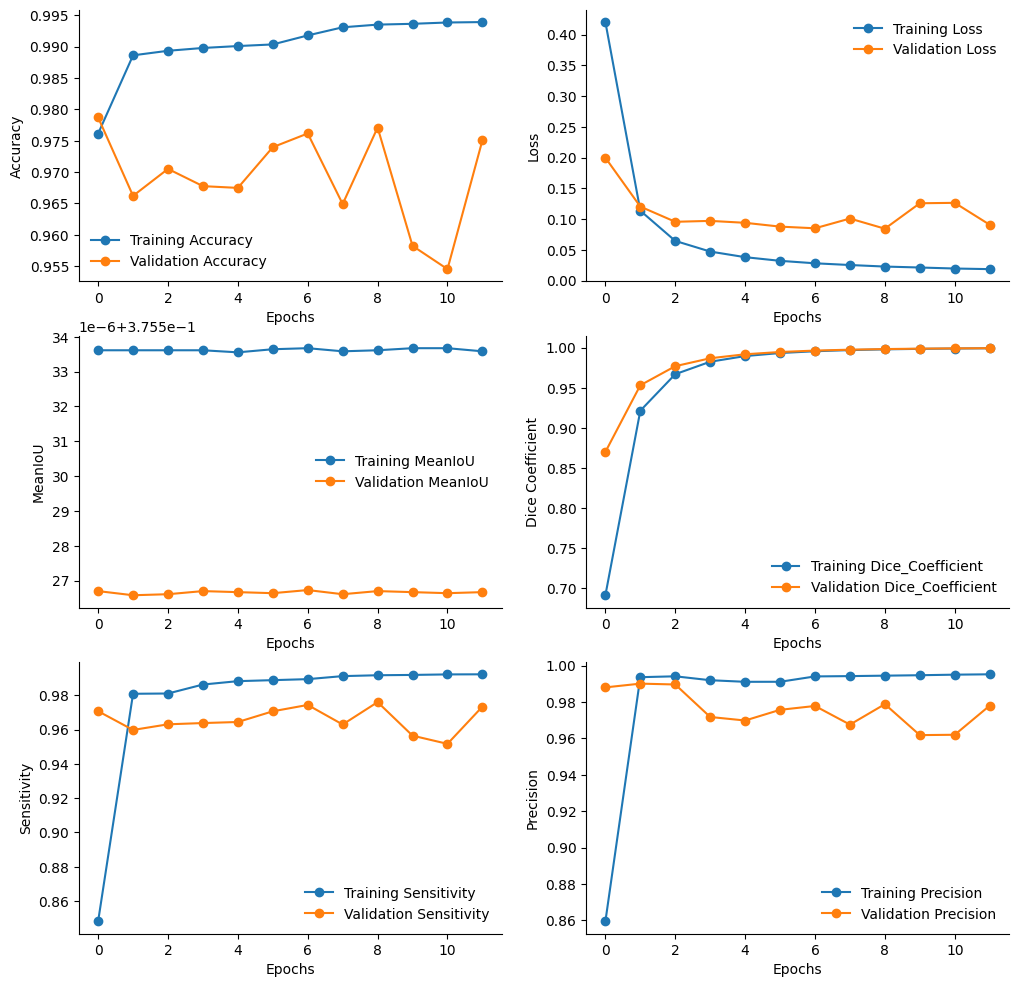

In [17]:
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(3,2,figsize=(12,12))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']
train_sensitivity = history.history['sensitivity']
val_sensitivity = history.history['val_sensitivity']
train_precision = history.history['precision']
val_precision = history.history['val_precision']

sns.despine()
ax[0,0].plot(epochs, train_acc, marker='o',
           label = 'Training Accuracy')
ax[0,0].plot(epochs, val_acc, marker='o',
           label = 'Validation Accuracy')
ax[0,0].legend(frameon=False)
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Accuracy')

sns.despine()
ax[0,1].plot(epochs, train_loss, marker='o',
           label ='Training Loss')
ax[0,1].plot(epochs, val_loss, marker='o',
           label = 'Validation Loss')
ax[0,1].legend(frameon=False)
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')

sns.despine()
ax[1,0].plot(epochs, train_mean_iou, marker='o',
           label = 'Training MeanIoU')
ax[1,0].plot(epochs, val_mean_iou, marker='o',
           label = 'Validation MeanIoU')
ax[1,0].legend(frameon=False)
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('MeanIoU')

sns.despine()
ax[1,1].plot(epochs, train_dice_coef, marker='o',
           label = 'Training Dice_Coefficient')
ax[1,1].plot(epochs, val_dice_coef, marker='o',
           label = 'Validation Dice_Coefficient')
ax[1,1].legend(frameon=False)
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Dice Coefficient')

sns.despine()
ax[2,0].plot(epochs, train_sensitivity, marker='o',
           label = 'Training Sensitivity')
ax[2,0].plot(epochs, val_sensitivity, marker='o',
           label = 'Validation Sensitivity')
ax[2,0].legend(frameon=False)
ax[2,0].set_xlabel('Epochs')
ax[2,0].set_ylabel('Sensitivity')

sns.despine()
ax[2,1].plot(epochs, train_precision, marker='o',
           label = 'Training Precision')
ax[2,1].plot(epochs, val_precision, marker='o',
           label = 'Validation Precision')
ax[2,1].legend(frameon=False)
ax[2,1].set_xlabel('Epochs')
ax[2,1].set_ylabel('Precision')
fig.show()

In [15]:
csv_logger = CSVLogger('/kaggle/working/evaluation_50.log')
model1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 67s 438ms/step - loss: 0.0867 - accuracy: 0.9742 - mean_io_u_1: 0.3755 - dice_coef: 0.9983 - precision: 0.9760 - sensitivity: 0.9730 - specificity: 0.9921 - dice_coef_necrotic: 1.0000 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000
test loss, test acc: [0.08671030402183533, 0.9741629362106323, 0.3755391240119934, 0.9982541799545288, 0.9759699702262878, 0.9729923605918884, 0.9920687675476074, 0.9999988079071045, 0.9999988079071045, 0.9999988079071045]
